<a href="https://colab.research.google.com/github/musical-shyam/Robust-AI/blob/main/ResNet_Defense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pre-Task: Training a New Clean Model to prevent Gradient Obfuscation**



## **Importing Required LIbraries**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import PIL.Image as Image
import random
import time # Using for checking training time

#Refer to: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## **Mounting to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Switching to GPU (if available)**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## **Data Loading and Pre-Processing**

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),])

# Changed the Batch Size to 128 for Best Results
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:02<00:00, 69.7MB/s]


## **Data Visualization (Before Augmentation)**

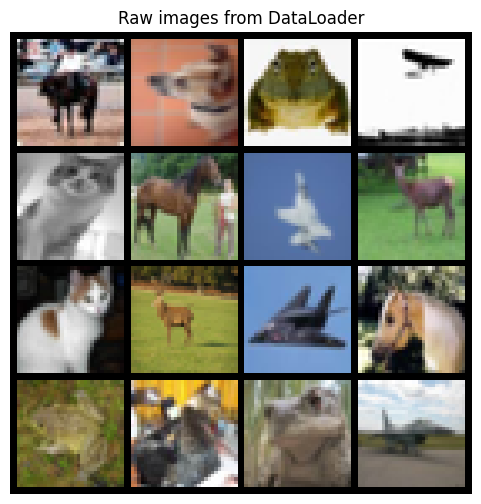

First 16 labels: ['horse', 'dog', 'frog', 'plane', 'cat', 'horse', 'plane', 'deer', 'cat', 'deer', 'plane', 'horse', 'frog', 'cat', 'frog', 'plane']


In [ ]:
def imshow_grid(img, labels):
    """
    Displays a grid of up to 16 images from a batch.
    (These are still unnormalized: just raw 0-1 from .ToTensor().)
    """
    img = img[:16]
    labels = labels[:16]
    npimg = torchvision.utils.make_grid(img, nrow=4).numpy()
    plt.figure(figsize=(6,6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Raw images from DataLoader")
    plt.axis('off')
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow_grid(images, labels)
print("First 16 labels:", [classes[l.item()] for l in labels[:16]])

## **Defining the ResNet-20 Architecture**

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        if self.training:
            # Padding for random crop
            x = F.pad(x, (4,4,4,4), mode='reflect')
            _, _, h, w = x.size()

            # Random Crop
            top = random.randint(0, h - 32)
            left = random.randint(0, w - 32)
            x = x[:, :, top:top + 32, left:left + 32]

            # Random Horizontal Flip
            if random.random() > 0.5:
                x = torch.flip(x, dims=[3])

        # Adding Normalization
        x = (x - 0.5) / 0.5

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet20():
    return ResNet(BasicBlock, [3, 3, 3])


net = ResNet20()
net = net.to(device)

## **Setting up the Hyperparameters**

In [ ]:
criterion = nn.CrossEntropyLoss()
# ctiterion = criterion.cuda()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-4 )
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
epochs= 200

## **Training the Model**

In [ ]:
start = time.time()

for epoch in range(epochs):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # store statistics
      running_loss += loss.item()


    # printing Loss
    print(f"[Epoch {epoch+1}] Loss: {running_loss / len(trainloader):.4f}")

    # set the learning rate scheduler
    scheduler.step()

print('Finished Training')
total_time = time.time() - start
print(f"Total Training Time: {total_time:.2f} seconds ({total_time / 60:.2f} minutes)")

[Epoch 1] Loss: 1.6596
[Epoch 2] Loss: 1.1937
[Epoch 3] Loss: 0.9371
[Epoch 4] Loss: 0.7854
[Epoch 5] Loss: 0.7014
[Epoch 6] Loss: 0.6420
[Epoch 7] Loss: 0.5994
[Epoch 8] Loss: 0.5646
[Epoch 9] Loss: 0.5411
[Epoch 10] Loss: 0.5241
[Epoch 11] Loss: 0.5044
[Epoch 12] Loss: 0.4885
[Epoch 13] Loss: 0.4725
[Epoch 14] Loss: 0.4601
[Epoch 15] Loss: 0.4455
[Epoch 16] Loss: 0.4488
[Epoch 17] Loss: 0.4382
[Epoch 18] Loss: 0.4256
[Epoch 19] Loss: 0.4215
[Epoch 20] Loss: 0.4108
[Epoch 21] Loss: 0.4039
[Epoch 22] Loss: 0.3978
[Epoch 23] Loss: 0.3954
[Epoch 24] Loss: 0.3830
[Epoch 25] Loss: 0.3847
[Epoch 26] Loss: 0.3764
[Epoch 27] Loss: 0.3766
[Epoch 28] Loss: 0.3728
[Epoch 29] Loss: 0.3654
[Epoch 30] Loss: 0.3610
[Epoch 31] Loss: 0.3600
[Epoch 32] Loss: 0.3578
[Epoch 33] Loss: 0.3459
[Epoch 34] Loss: 0.3482
[Epoch 35] Loss: 0.3446
[Epoch 36] Loss: 0.3390
[Epoch 37] Loss: 0.3410
[Epoch 38] Loss: 0.3439
[Epoch 39] Loss: 0.3344
[Epoch 40] Loss: 0.3366
[Epoch 41] Loss: 0.3265
[Epoch 42] Loss: 0.3276
[

## **Storing the Model**

In [ ]:
PATH = '/content/drive/My Drive/Colab Notebooks/CS 680A: AI Security/Models/defense_baseline.pth'
torch.save(net.state_dict(), PATH)

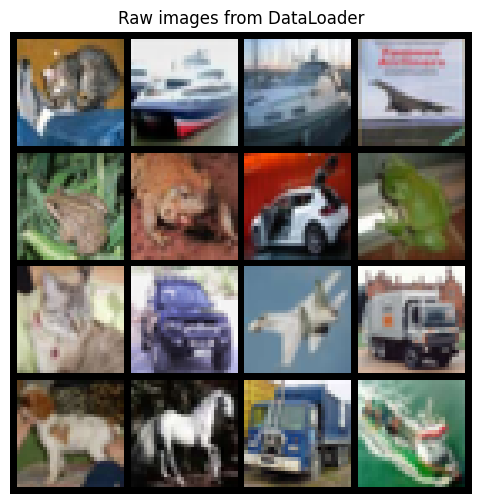

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow_grid(images, labels)

## **Loading the Model**

In [ ]:
net = ResNet20()
net = net.to(device)
PATH = '/content/drive/My Drive/Colab Notebooks/CS 680A: AI Security/Models/defense_baseline.pth'
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [ ]:
outputs = net(images.to(device))

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


## **Calculating Accuracy Scores**

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total:.2f} %')

Accuracy of the network on the 10000 test images: 91.00 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label.cuda() == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.2f} %')

Accuracy for class: plane is 93.60 %
Accuracy for class: car   is 96.30 %
Accuracy for class: bird  is 89.00 %
Accuracy for class: cat   is 82.60 %
Accuracy for class: deer  is 94.00 %
Accuracy for class: dog   is 88.00 %
Accuracy for class: frog  is 95.20 %
Accuracy for class: horse is 93.60 %
Accuracy for class: ship  is 94.80 %
Accuracy for class: truck is 93.90 %


# **Task 1: Performing Adversarial Training as a Defense to FGSM attacks**

## **Defining the FGSM Attack**

In [ ]:
def fgsm_attack(model, images, labels, epsilon):
    """
    Creates adversarial images via FGSM:
      adv_x = x + epsilon * sign( dLoss/dx )
    """

    # Make a copy so we don't mess up original input
    images = images.clone().detach().to(device)
    labels = labels.to(device)

    # Require gradient
    images.requires_grad = True

    # Forward
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)

    # Backward
    model.zero_grad()
    loss.backward()

    # Collect the sign of the gradients
    grad_sign = images.grad.data.sign()

    # Create adversarial image (clamp to [0,1] if your input domain is 0..1)
    adv_images = images + epsilon * grad_sign
    adv_images = torch.clamp(adv_images, 0.0, 1.0)

    return adv_images.detach()

## **Defining the Adversarial Training Loop**

In [ ]:
def adversarial_train(model, trainloader, epochs=20, epsilon=0.031, lr=0.01):
    """
    Perform basic FGSM-based adversarial training:
      - For each batch:
          1) Generate adv images with FGSM at `epsilon`.
          2) Forward pass on adv images
          3) Backprop + update
    """
    # Switch to train mode
    model.train()

    # Optimizer can match your original or new hyperparams
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=2e-4)


    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Step 1) Generate adversarial examples
            adv_inputs = fgsm_attack(model, inputs, labels, epsilon=epsilon)

            # Step 2) Forward on adv images
            optimizer.zero_grad()
            outputs = model(adv_inputs)
            loss = F.cross_entropy(outputs, labels)

            # Step 3) Backprop and update
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        print(f"[Epoch {epoch+1}/{epochs}] FGSM adv training loss: {avg_loss:.4f}")

    print("Finished Adversarial Training!")
    return model

## **Performing Adversarial Training**

In [ ]:
model_adv = ResNet20().to(device)
PATH = '/content/drive/My Drive/Colab Notebooks/CS 680A: AI Security/Models/defense_baseline.pth'
model_adv.load_state_dict(torch.load(PATH, weights_only=True))

model_adv = adversarial_train(model_adv, trainloader, epochs=20, epsilon=0.031, lr=0.01)

[Epoch 1/20] FGSM adv training loss: 1.4316
[Epoch 2/20] FGSM adv training loss: 1.3183
[Epoch 3/20] FGSM adv training loss: 1.2187
[Epoch 4/20] FGSM adv training loss: 1.0940
[Epoch 5/20] FGSM adv training loss: 1.0935
[Epoch 6/20] FGSM adv training loss: 0.9988
[Epoch 7/20] FGSM adv training loss: 0.9379
[Epoch 8/20] FGSM adv training loss: 0.8480
[Epoch 9/20] FGSM adv training loss: 0.5755
[Epoch 10/20] FGSM adv training loss: 0.4210
[Epoch 11/20] FGSM adv training loss: 0.3861
[Epoch 12/20] FGSM adv training loss: 0.3732
[Epoch 13/20] FGSM adv training loss: 0.3496
[Epoch 14/20] FGSM adv training loss: 0.3288
[Epoch 15/20] FGSM adv training loss: 0.3111
[Epoch 16/20] FGSM adv training loss: 0.3275
[Epoch 17/20] FGSM adv training loss: 0.3268
[Epoch 18/20] FGSM adv training loss: 0.3201
[Epoch 19/20] FGSM adv training loss: 0.3151
[Epoch 20/20] FGSM adv training loss: 0.2957
Finished Adversarial Training!


In [ ]:
torch.save(model_adv.state_dict(), '/content/drive/My Drive/Colab Notebooks/CS 680A: AI Security/Models/defense_adv.pth')

## **Defining the Evaluation Function**

In [ ]:
def evaluate_accuracy_vs_epsilon(model, loader, eps_list):
    """
    Returns a list of accuracies for FGSM attacks at each epsilon in eps_list.
    """
    accuracies = []
    model.eval()
    for eps in eps_list:
        correct = 0
        total = 0

        # Evaluate on the FGSM-perturbed images
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            # Create adv images
            adv_images = fgsm_attack(model, images, labels, epsilon=eps)
            outputs = model(adv_images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100.0 * correct / total
        accuracies.append(acc)
    return accuracies

## **Evaluating Both the Models**

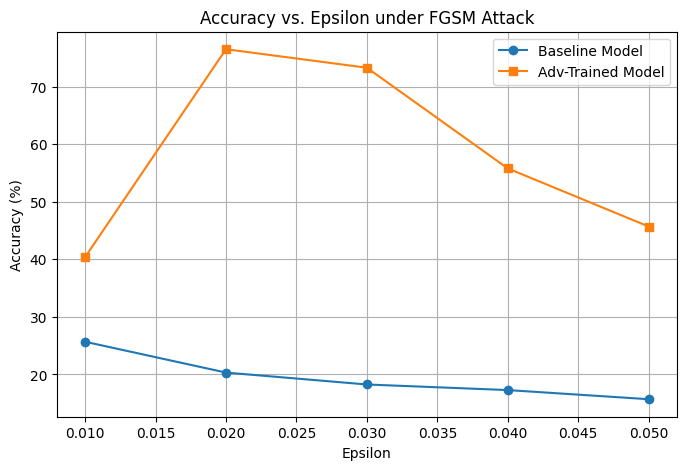

In [ ]:
epsilons = [0.01, 0.02, 0.03, 0.04, 0.05]

# Evaluate baseline model
acc_baseline = evaluate_accuracy_vs_epsilon(net, testloader, epsilons)

# Evaluate adv-trained model
acc_advtrained = evaluate_accuracy_vs_epsilon(model_adv, testloader, epsilons)


# Plot the results
plt.figure(figsize=(8,5))
plt.plot(epsilons, acc_baseline, marker='o', label='Baseline Model')
plt.plot(epsilons, acc_advtrained, marker='s', label='Adv-Trained Model')
plt.title("Accuracy vs. Epsilon under FGSM Attack")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

# **Task 2: CLP based defense on Backdoor model with BadNet Trigger**

## **Reverting Back to the old Data Pipeline and Architecture**

In [ ]:
transform = transforms.Compose(
    # Adding Random Croping and Flipping for Best Results
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Changed the Batch Size to 128 for Best Results
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 50.9MB/s]


In [ ]:
class BasicBlock_(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock_, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet_(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet20_():
    return ResNet_(BasicBlock_, [3, 3, 3])

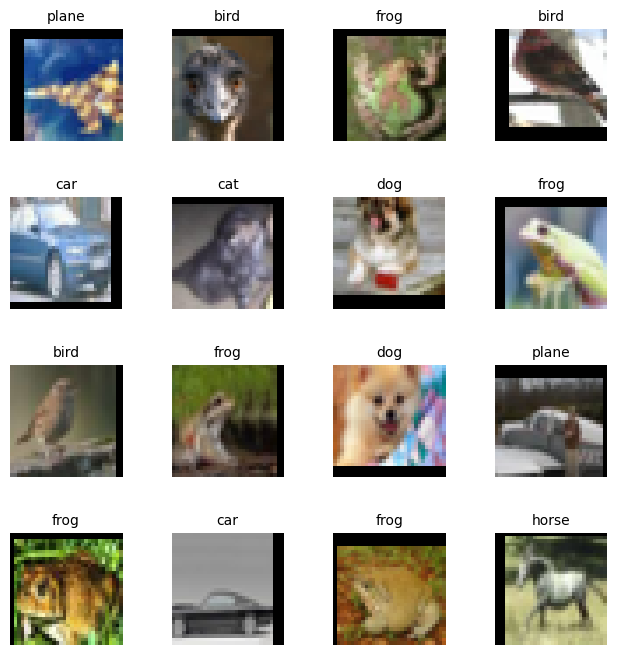

In [ ]:
def imshow(img, labels):
    img = img[:16] #shows the first 16 images
    labels = labels[:16] #shows the first 16 labels
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()

    # plt.figure(figsize=(10, 10))
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.show()

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    fig.subplots_adjust(hspace=0.5)  # Adjust space between images

    for i, ax in enumerate(axes.flat):
        if i < 16:
            img = np.transpose(npimg[i], (1, 2, 0))
            ax.imshow(img)
            ax.set_title(classes[labels[i].item()], fontsize=10)
            ax.axis("off")  # Remove axes

    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(images, labels)

## **Defining the CLP Defense Function**

In [ ]:
def CLP(net, u):
    new_net = ResNet20_().to(device)
    params = net.state_dict()
    for name, m in net.named_modules():
        if isinstance(m, nn.BatchNorm2d):
            std = m.running_var.sqrt()
            weight = m.weight

            channel_lips = []
            for idx in range(weight.shape[0]):
                # Combining weights of convolutions and BN
                w = conv.weight[idx].reshape(conv.weight.shape[1], -1) * (weight[idx]/std[idx]).abs()
                channel_lips.append(torch.svd(w.cpu())[1].max())
            channel_lips = torch.Tensor(channel_lips)

            index = torch.where(channel_lips>channel_lips.mean() + u*channel_lips.std())[0]

            params[name+'.weight'][index] = 0
            params[name+'.bias'][index] = 0
            print(f"Pruned {len(index)} channel(s) at layer={name} with threshold u={u}")

       # Convolutional layer should be followed by a BN layer by default
        elif isinstance(m, nn.Conv2d):
            conv = m

    new_net.load_state_dict(params)
    return new_net

## **Adding the Functions Needed for Evaluation**

In [ ]:
def add_trigger(img, trigger, position="bottom_left"):
  img = img.clone()
  c, h, w = img.shape

  if position == "bottom_left":
    img[:, -trigger.shape[1]:, :trigger.shape[2]] = trigger
  elif position == "bottom_right":
    img[:, -trigger.shape[1]:, -trigger.shape[2]:] = trigger
  elif position == "top_left":
    img[:, :trigger.shape[1], :trigger.shape[2]] = trigger
  elif position == "top_right":
    img[:, :trigger.shape[1], -trigger.shape[2]:] = trigger

  return img

def evaluate_poisoned_model(model, testloader, trigger, target_class, trigger_size, position="bottom_left"):

    model.eval()
    correct_clean = 0
    total_clean = 0
    correct_asr = 0
    total_asr = 0

    # Evaluate clean accuracy
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_clean += labels.size(0)
            correct_clean += (predicted == labels).sum().item()

    # Evaluate attack success rate (ASR)
    with torch.no_grad():
        for images, _ in testloader:
            # Move images to CPU for triggering (if your add_trigger expects CPU tensors)
            # and then move back to CUDA.
            # If your add_trigger function already handles that, adjust accordingly.
            poisoned_images = []
            for img in images:
                # Ensure the image is on CPU before applying the trigger
                img_cpu = img.cpu()
                poisoned_img = add_trigger(img_cpu, trigger, position)
                poisoned_images.append(poisoned_img)
            # Stack all images and move to CUDA
            poisoned_images = torch.stack(poisoned_images).to(device)
            outputs = model(poisoned_images)
            _, predicted = torch.max(outputs, 1)
            total_asr += poisoned_images.size(0)
            # Count as success if the model predicts the target class
            correct_asr += (predicted == target_class).sum().item()

    clean_accuracy = 100 * correct_clean / total_clean
    asr = 100 * correct_asr / total_asr if total_asr > 0 else 0

    return clean_accuracy, asr

In [ ]:
def evaluate_clean_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    return accuracy

## **Evaluating the Defense on Backdoored Model**

In [ ]:
model_path = "/content/drive/My Drive/Colab Notebooks/CS 680A: AI Security/Models/poisoned_10_bottom_left_cifar_10.pth"

trigger_size = (9,9)
trigger_path = "/content/drive/My Drive/Colab Notebooks/CS 680A: AI Security/Images/S_Sign_Trigger.jpg"
target_class = 2

thresholds = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
results = []

trigger = Image.open(trigger_path).convert("RGB")
transform_image = transforms.Compose([transforms.Resize(trigger_size), transforms.ToTensor()])
trigger = transform_image(trigger)
for t in thresholds:
    # Load a fresh copy of the backdoored model
    n = ResNet20_().to(device)
    n.load_state_dict(torch.load(model_path, map_location=device))

    new_net = ResNet20_().to(device)
    new_net = CLP(n, t)


    torch.save(new_net.state_dict(), f'/content/drive/My Drive/Colab Notebooks/CS 680A: AI Security/Models/CLP_on_Backdoored_with_{t}_threshold.pth')


    clean_acc, attack_success_rate = evaluate_poisoned_model(new_net, testloader, trigger, target_class=2, trigger_size= trigger_size, position="bottom_left")

    # 4Print or store results

    print(f"\nThreshold={t} => Clean Accuracy: {clean_acc:.2f}% | ASR = {attack_success_rate:.2f}%\n")
    results.append((t, clean_acc, attack_success_rate))

Pruned 2 channel(s) at layer=bn1 with threshold u=1.0
Pruned 3 channel(s) at layer=layer1.0.bn1 with threshold u=1.0
Pruned 3 channel(s) at layer=layer1.0.bn2 with threshold u=1.0
Pruned 2 channel(s) at layer=layer1.1.bn1 with threshold u=1.0
Pruned 4 channel(s) at layer=layer1.1.bn2 with threshold u=1.0
Pruned 3 channel(s) at layer=layer1.2.bn1 with threshold u=1.0
Pruned 4 channel(s) at layer=layer1.2.bn2 with threshold u=1.0
Pruned 4 channel(s) at layer=layer2.0.bn1 with threshold u=1.0
Pruned 6 channel(s) at layer=layer2.0.bn2 with threshold u=1.0
Pruned 4 channel(s) at layer=layer2.0.shortcut.1 with threshold u=1.0
Pruned 3 channel(s) at layer=layer2.1.bn1 with threshold u=1.0
Pruned 7 channel(s) at layer=layer2.1.bn2 with threshold u=1.0
Pruned 5 channel(s) at layer=layer2.2.bn1 with threshold u=1.0
Pruned 4 channel(s) at layer=layer2.2.bn2 with threshold u=1.0
Pruned 9 channel(s) at layer=layer3.0.bn1 with threshold u=1.0
Pruned 9 channel(s) at layer=layer3.0.bn2 with threshold 

In [ ]:
print("=== Pruning Results ===")
for (th, acc, asr) in results:
    print(f"Threshold {th} | Clean Acc={acc:.2f}% | Attack Success Rate={asr:.2f}%")

=== Pruning Results ===
Threshold 1.0 | Clean Acc=13.23% | Attack Success Rate=0.00%
Threshold 2.0 | Clean Acc=67.70% | Attack Success Rate=5.07%
Threshold 3.0 | Clean Acc=74.75% | Attack Success Rate=18.83%
Threshold 4.0 | Clean Acc=83.80% | Attack Success Rate=31.87%
Threshold 5.0 | Clean Acc=83.79% | Attack Success Rate=32.33%
Threshold 6.0 | Clean Acc=84.16% | Attack Success Rate=100.00%
Threshold 7.0 | Clean Acc=83.93% | Attack Success Rate=99.99%
Threshold 8.0 | Clean Acc=83.76% | Attack Success Rate=100.00%
Threshold 9.0 | Clean Acc=84.22% | Attack Success Rate=100.00%


In [ ]:
import pandas as pd
from tabulate import tabulate

# Create the DataFrame
df = pd.DataFrame(results, columns=["Threshold", "Clean Accuracy (%)", "Attack Success Rate (%)"])
df = df.round(2).astype(str)
df.style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]).hide(axis='index').set_caption("<b>Pruning Results (CLP on Backdoored Model)</b>")


Threshold,Clean Accuracy (%),Attack Success Rate (%)
1.0,13.32,0.0
2.0,67.74,5.22
3.0,75.18,18.75
4.0,84.37,32.39
5.0,83.79,32.3
6.0,84.51,100.0
7.0,83.89,100.0
8.0,84.66,100.0
9.0,84.33,100.0


## **Evaluating the Defense on Clean Model**

In [ ]:
model_path = "/content/drive/My Drive/Colab Notebooks/CS 680A: AI Security/Models/attack_baseline.pth"

t = 3.0

net = ResNet20_().to(device)
net.load_state_dict(torch.load(model_path, map_location=device))

new_net = ResNet20_().to(device)
new_net = CLP(net, t)


torch.save(new_net.state_dict(), f'/content/drive/My Drive/Colab Notebooks/CS 680A: AI Security/Models/CLP_on_Clean_Model_with_{t}_threshold.pth')

# Evaluating how it performs now (clean accuracy)
clean_acc = evaluate_clean_accuracy(new_net, testloader)
print("=== Pruning Results ===")
print(f"Threshold {t} | Clean Acc={clean_acc:.2f}%")

Pruned 0 channel(s) at layer=bn1 with threshold u=3.0
Pruned 0 channel(s) at layer=layer1.0.bn1 with threshold u=3.0
Pruned 0 channel(s) at layer=layer1.0.bn2 with threshold u=3.0
Pruned 0 channel(s) at layer=layer1.1.bn1 with threshold u=3.0
Pruned 0 channel(s) at layer=layer1.1.bn2 with threshold u=3.0
Pruned 0 channel(s) at layer=layer1.2.bn1 with threshold u=3.0
Pruned 0 channel(s) at layer=layer1.2.bn2 with threshold u=3.0
Pruned 0 channel(s) at layer=layer2.0.bn1 with threshold u=3.0
Pruned 1 channel(s) at layer=layer2.0.bn2 with threshold u=3.0
Pruned 0 channel(s) at layer=layer2.0.shortcut.1 with threshold u=3.0
Pruned 0 channel(s) at layer=layer2.1.bn1 with threshold u=3.0
Pruned 0 channel(s) at layer=layer2.1.bn2 with threshold u=3.0
Pruned 0 channel(s) at layer=layer2.2.bn1 with threshold u=3.0
Pruned 0 channel(s) at layer=layer2.2.bn2 with threshold u=3.0
Pruned 0 channel(s) at layer=layer3.0.bn1 with threshold u=3.0
Pruned 0 channel(s) at layer=layer3.0.bn2 with threshold 

In [ ]:
clean_acc = evaluate_clean_accuracy(net, testloader)
print(f"Clean Acc={clean_acc:.2f}%")

Clean Acc=89.68%
